In [1]:
import numpy as np
import ipdb
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp 
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class dynamical_system:
    '''
    A set of inheritable methods to solve dynamical systems
    '''
    def integrate(self,tinit, tmax, dt, x0,method='RK45'):
        '''
        Solves a differental equation from tinit to tmax and storing the 
        solution value dt intervals.
        
        Args: 
            tinit: inital time of the system
            tmax: final time of the system
            x0: initial value of the system
            method: numerical scheme to compute the solution
        
        Returns:
            sol: the solution from solve_ivp that contains integration parameters
        '''
        t_eval =  np.arange(tinit, tmax, dt)
        sol=solve_ivp(self.rhs, [tinit, tmax], x0, t_eval = t_eval,method='RK45')
        self.xs = (sol.y).T
        self.ts = sol.t
        return sol
    
    def trajectory_plot(self,ind=[0,1,2]):
        '''
        Three dimension plot of a cross section of phase space
        
        Args:
            ind: indices of the states used to generate the cross section
        '''
        fig=plt.figure()
        ax = fig.gca(projection='3d')
        #generate plot object
        ax.plot(self.xs[:,ind[0]],self.xs[:,ind[1]],self.xs[:,ind[2]])
        
        #label axes
        ax.set_xlabel('$x_'+str(ind[0])+'$')
        ax.set_ylabel('$x_'+str(ind[1])+'$')
        ax.set_zlabel('$x_'+str(ind[2])+'$')
        plt.show()
        
    def evolution_plot(self,ind=None,legnames=None):
        '''
        Plot of evolution of states with respect to time
        
        Args:
            ind: indices of the states plot evolution
        '''
        
        if (ind is not None):
            #generate plot object
            plt.plot(self.ts,self.xs[:,ind])
            #legend
            if (legnames is None):
                legnames = ['$x_' + str(i) + '$' for i in ind]
        else:
            #generate plot object
            plt.plot(self.ts,self.xs)
            #legend
            ind = (self.xs).shape[1]
            if (legnames is None):
                legnames = ['$x_' + str(i) + '$' for i in range(0,ind)]
            
            
        #label axes
        plt.xlabel('$t$')
        plt.ylabel('$x$')
        
        plt.legend(legnames,loc="upper right")
        plt.show()

# Lorenz 96

In [3]:
class Lorenz96(dynamical_system):
    def __init__(self, N, F):
        '''
        creates a Lorenz class with N terms and forcing, F
        
        Args:
            N: number of terms in the dynamical system
            F: forcing term
        '''
        self.N = N
        self.F = F
    
    def rhs(self, t, x):
        '''
        Calculates dx/dt of the Lorenz equation at x and time = t.
        See https://en.wikipedia.org/wiki/Lorenz_96_model.
        
        Args:
            x: the state of the dynamical system at time t
            t: the current time of dynamical system
            
        Returns:
            dxdt: vector field at dxdt
        '''
        #number of terms in the dynamical system
        N = self.N
        
        #Forcing term
        F = self.F
        
        #initialize rhs vector
        dxdt = np.zeros(N)
        
        #edge cases
        dxdt[0] =  (x[1] - x[-2])*x[-1] - x[0] + F
        dxdt[1] =  (x[2] - x[-1])*x[0] - x[1] + F
        dxdt[N-1] =  (x[0] - x[N-3])*x[N-2] - x[N-1] + F

        #non-edge cases
        if (N > 3):
            dxdt[2:(N-1)] =  (x[3:N] - x[:(N-3)])*x[1:(N-2)] - x[2:(N-1)] + F
        
        return dxdt

In [4]:
import numpy as np
# these are our constants
N = 36  # number of variables
F = 8  # forcing
x0 = F*np.ones(N) # initial state (equilibrium)
x0[19] += 0.01 # add small perturbation to 20th variable
tinit = 0
tmax = 10.0
dt = 0.01

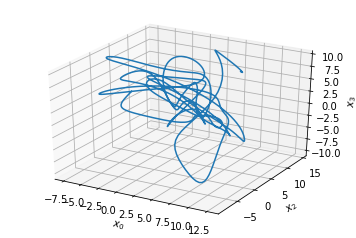

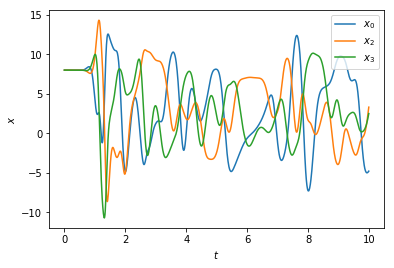

In [5]:
lorenz96 = Lorenz96(N,F)
sol = lorenz96.integrate(tinit,tmax, dt ,x0)
lorenz96.trajectory_plot([0,2,3])
lorenz96.evolution_plot([0,2,3])

# Kuramoto Models

In [6]:
class Kuramoto(dynamical_system):
    def __init__(self, N, K, omega):
        '''
        creates a Kuramoto class with N oscillators, coupling term K
        and natural frequency, omega
        
        Args:
            N: number of oscillators
            K: number
        '''
        #number of oscillators
        self.N = N
        #coupling term
        self.K = K
        #natural frequency
        self.omega = omega
        
    def rhs(self,t,x):
        '''
        Calculates dx/dt of the Kuramoto equation at state, x, and time, t.
        See https://en.wikipedia.org/wiki/Lorenz_96_model.
        
        Args:
            x: the state of the dynamical system at time t
            t: the current time of dynamical system
            
        Returns:
            dxdt: the vector field at x, t.
        '''
        #natural frequency
        omega = self.omega
        #number of oscillators
        N = self.N
        #coupling term
        K = self.K
        
        #calculate dxdt
        temp = np.reshape(x, (N,-1))
        xmat = np.repeat(temp,N,axis=1)
        dxdt = omega + (K/N)*np.sum(np.sin(xmat - x),axis=0)
        return dxdt

In [7]:
# these are our constants
N = 8  # number of variables
K = 10.0 #coupling
omega =  np.pi*np.random.uniform(size=N)   # natural frequency
theta0 = 2*np.pi*np.random.uniform(size=N) # initial state 
tinit = 0.0
tmax = 10.0
dt =  0.001

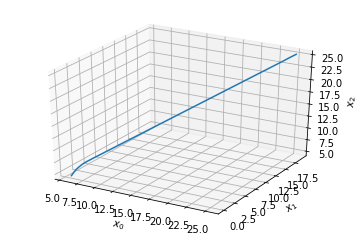

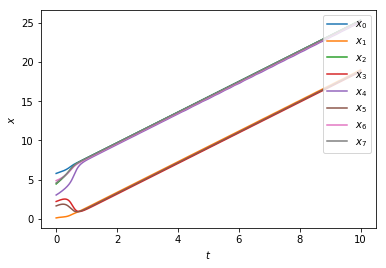

In [8]:
kuramoto = Kuramoto(N,K,omega)
sol = kuramoto.integrate(tinit, tmax, dt, theta0)
kuramoto.trajectory_plot()
kuramoto.evolution_plot()

# Weiner Processes

In [9]:
class sdes:
    def __init__(self, a_fun, b_fun):
        '''
        Creates an SDE of the form dX = a(X,t)dt + b(X,t)dW(t)
        
        Args:
           a_fun = a(X,t)
           b_fun = b(X,t)
        '''
        self.a_fun = a_fun
        self.b_fun = b_fun
    
    def euler_maruyama(self,tinit,x_init,tmax,N):
        '''
        Implements Euler Maruyama for an SDE. 
        See https://en.wikipedia.org/wiki/Euler-Maruyama_method
        
        Args: 
            tinit: initial time
            x_init: inital state of x
            tmax: final time
            N: number of time points
            
        Returns:
            X at time points, tinit + i*(tmax-tinit)/N.
        '''
        a_fun = self.a_fun 
        b_fun = self.b_fun
        
        dt = (tmax-tinit)/(N-1)
        dW = np.random.normal(loc=0.0, scale=np.sqrt(dt),size=N-1)
        X = np.zeros(N)
        t = np.zeros(N)
        X[0] = x_init
        t[0] = tinit
        for i in range(1,N):
            X[i] = X[i-1] + a_fun(X[i-1])*dt + b_fun(X[i-1])*dW[i-1] 
            t[i] = t[i-1] + dt
        self.Xs = X
        self.ts = t
        return X
    
    def plot(self):
        '''
        Plots the solution X(t)
        '''
        plt.plot(self.ts,self.Xs)
        plt.xlabel('$t$')
        plt.ylabel('$X$')
        plt.show()

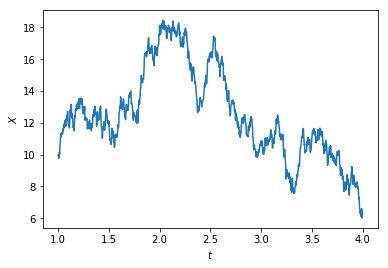

In [10]:
def a_fun(X):
    return -2
def b_fun(X):
    return 5

sodes=sdes(a_fun,b_fun)
sol = sodes.euler_maruyama(1.0,10.0,4.0,1000)
sodes.plot()

# Simple Enzymatic Reaction

Dynamical system for the simple enzymatic reaction:

$X_1 + X_2\rightarrow^{k_1} X_1E_1 \rightarrow^{k_3} X_2E_1 \rightarrow^{k_5} X_2 + E_1$


$X_1 + X_2\leftarrow^{k_2} X_1E_1 \leftarrow^{k_4} X_2E_1 \leftarrow^{k_6} X_2 + E_1$

In [11]:
class enzymatic_reaction(dynamical_system):
    def __init__(self, reaction_rates):
        '''
        creates a dynamical system for a simple enzymatic reaction
        with reaction rates, reaction_rates.
        '''
        self.reaction_rates = reaction_rates
        
    def rhs(self,t,x):
        '''
        Calculates dx/dt of the simple enzymatic reaction
        with mass action kinetics at state, x, and time, t.
        See https://en.wikipedia.org/wiki/Lorenz_96_model.
        
        Args:
            x: the state of the dynamical system at time t
            t: the current time of dynamical system
            
        Returns:
            [dX1dt,dX1E1dt,dX1E1dt,dX2E1dt,dE1dt]:
                dx/dt of the system
        '''
        reaction_rates = self.reaction_rates 
        
        #evolution of X1
        dX1dt = -reaction_rates[0]*x[0]*x[4] + reaction_rates[1]*x[2]
        
        #evolution of X2
        dX2dt = -reaction_rates[5]*x[1]*x[4] + reaction_rates[4]*x[3]
        
        #evolution of X1E1

        dX1E1dt = reaction_rates[0]*x[0]*x[4] - reaction_rates[1]*x[2] \
                -reaction_rates[2]*x[2] + reaction_rates[3]*x[3]
        
        #evolution of X2E1

        dX2E1dt = reaction_rates[2]*x[2] - reaction_rates[3]*x[3] \
                 + reaction_rates[5]*x[1]*x[4] - reaction_rates[4]*x[3]
        
        #evolution of E1
        
        dE1dt = -reaction_rates[0]*x[0]*x[4] + reaction_rates[1]*x[2] \
                + reaction_rates[4]*x[3] - reaction_rates[5]*x[1]*x[4]
        
        return [dX1dt,dX2dt,dX1E1dt,dX2E1dt,dE1dt]
    
    def evolution_plot(self):
        legnames =  ['$[X_1]$','$[X_2]$',
                    '$[X_1E_1]$','$[X_2E_1]$',
                    '$[E_1]$']
        dynamical_system.evolution_plot(self,legnames=legnames)

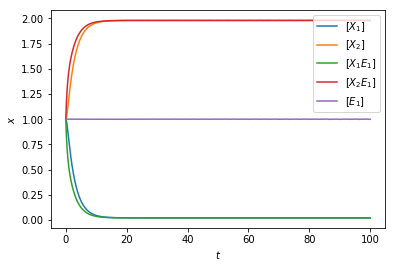

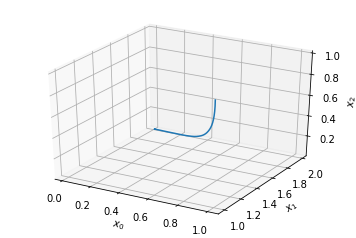

In [12]:
chemical_obj=enzymatic_reaction([1.0,1.0,1.0,1e-2,1.0,1.0])
tinit = 0.0
tmax = 100.0
dt = 0.01
sol = chemical_obj.integrate(tinit,tmax,dt,[1.0,1.0,1.0,1.0,1.0])
chemical_obj.evolution_plot()
chemical_obj.trajectory_plot()